In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
sys.path.append('..')
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
from forecast import *
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
from scipy.stats import pearsonr as pc
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
# DROOT = '/home/ubuntu/datasets-aux/checkpoints/old'
# GROOT = '/home/ubuntu/traffic/data/graphs_random'
DROOT = '/home/ubuntu/datasets-aux/checkpoints/checkpoints'
GROOT = '/home/ubuntu/traffic/data/graphs'

In [5]:
models = [
    'rnn',
    'mpfcast',
]

### Check all weights are present

In [6]:
check_files = glob('%s/mpfcast/*' % DROOT)
# check_files = glob('%s/mpfcast/400950-400951*' % DROOT)
len(check_files)

5

In [7]:
for mname in models:
    
    fls = glob('%s/%s/*' % (DROOT, mname))
#     assert len(check_files) == len(fls)
    
    fnames = [fileName(fl) for fl in fls]
    for check in check_files:
        if fileName(check) not in fnames:
            print('Missing - %s: %s' % (mname, check))

In [10]:
hopmap = {}
for mname in models:
    wfiles = [fname.replace('mpfcast', mname) for fname in check_files]
#     wfiles = glob('/home/ubuntu/datasets-aux/checkpoints/%s/*' % mname)
    for wname in wfiles:
        tag = fileName(wname)
        hop = int(tag.split('_n')[1])
        seg = tag.split('_n')[0]
        if hop not in hopmap: hopmap[hop] = {}
        if seg not in hopmap[hop]: hopmap[hop][seg] = {}
        hopmap[hop][seg][mname] = wname
print(len(hopmap), len(hopmap[1]))

5 1


In [11]:
from models.temporal.RNN import *
from models.MPRNN import *
from models.Variants import *

def load_mprnn(vs, adj, hops, wpath):
    model = MPRNN_FCAST(
        nodes=vs, adj=adj, 
        iters=hops,
        iter_indep=False,

        hidden_size=128, 
        verbose=False)

    model.to(device)
    model.device = device
    model.hops = hops
    model.load(wpath=wpath, verbose=False)
    return model

def load_rnn(nnodes, wpath):
    model = RNN(hidden_size=256, steps=nnodes).to(device)
    sd = torch.load(wpath)
#     print(sd.keys())
    model.load_state_dict(sd)
    model.device = device
    return model

In [13]:
def flatten(ls, level):
    if level == 3:
        return [ent for location in ls for seg in location for ent in seg]
    elif level == 2:
        return [seg for location in ls for seg in location]
    elif level == 1:
        return ls
def flat_mean(ls, level=3):
    return np.mean(flatten(ls, level))

# def mean_twice(ls):
#     return np.mean([ent for location in ls for seg in location for ent in seg])

In [14]:
TEST_HIST = 2 # Ideally full 18 days
# TEST_HIST = 18
HOP_MAX=5
TEST_HOPS = min(HOP_MAX, len(hopmap))
print('Testing for hops:', TEST_HOPS)

Testing for hops: 5


In [15]:
errs_byhop = []
corrs_byhop = []
for hop in range(1, TEST_HOPS+1):
    t0 = time()
    segs = hopmap[hop]
    errs_bymodel = { mname:list() for mname in models }
    corrs_bymodel = { mname:list() for mname in models }
    
    for seg, weights in tqdm(segs.items()):
        graph_file = '%s/%s_n%d.json' % (GROOT, seg, hop)
        vs, adj = read_graph(graph_file, verbose=False, named_adj=True)

        testset = SpotHistory(
            vs, 'test', 1, 
            lag=None, res=10, 
            shuffle=False, verbose=False)

        errs = []
        corrs = []
        mprnn = load_mprnn(vs, adj, 3, weights['mpfcast'])
        for ii in range(len(testset)):
            if len(testset[ii]) < 40:
                continue
            if ii > TEST_HIST:
                break
            sqerr, datamat = forecast_mprnn(
                testset[ii], mprnn, graph_file, 
                twoway=True,
                verbose=False, plot=False)
            errs.append(sqerr)

            ytrue = testset[ii][1:, 0]
            yhat = datamat[vs[0]]
            corr, pval = pc(yhat, ytrue)
            corrs.append(corr)
            
        errs_bymodel['mpfcast'].append(errs)
        corrs_bymodel['mpfcast'].append(corrs)

        errs = []
        corrs = []
        rnn = load_rnn(len(vs), weights['rnn'])
        for ii in range(len(testset)):
            if len(testset[ii]) < 40:
                continue
            if ii > TEST_HIST:
                break
            sqerr, datamat = forecast_rnn(
                testset[ii], rnn, graph_file, 
                twoway=True,
                verbose=False, plot=False)
            errs.append(sqerr)
            
            ytrue = testset[ii][1:, 0]
            yhat = datamat[vs[0]][:-1]
            corr, pval = pc(yhat, ytrue)
            corrs.append(corr)
            
        errs_bymodel['rnn'].append(errs)
        corrs_bymodel['rnn'].append(corrs)
    
    print('Hops:', hop, '(%.2fs)' % (time() - t0))
    for mname in models:
        print(mname, flat_mean(errs_bymodel[mname]) ** 0.5)
        print('    ', flat_mean(corrs_bymodel[mname], level=2))
    errs_byhop.append(errs_bymodel)
    corrs_byhop.append(corrs_bymodel)

  0%|          | 0/1 [00:00<?, ?it/s]

Hops: 1 (20.22s)
rnn 1.9228857294980732
     0.6759318474064792
mpfcast 2.5247787642268893
     0.43438973848470885


  0%|          | 0/1 [00:00<?, ?it/s]

Hops: 2 (3.72s)
rnn 2.494890168533378
     0.5744692709497238
mpfcast 1.9283758718249229
     0.6200356423070975


  0%|          | 0/1 [00:00<?, ?it/s]

Hops: 3 (5.17s)
rnn 2.176174890742914
     0.5459665689849539
mpfcast 2.3473889715262417
     0.4979247699750471


  0%|          | 0/1 [00:00<?, ?it/s]

Hops: 4 (6.61s)
rnn 4.993314032059923
     -0.3770001232985895
mpfcast 3.200631145420131
     0.0987407874989703


100%|██████████| 1/1 [00:08<00:00,  8.13s/it]

Hops: 5 (8.13s)
rnn 4.357544466363701
     -0.09227524976396635
mpfcast 3.0152975515496165
     0.038480737849050074


In [134]:
print('\t& ' + ' & '.join([('k=%d'% kk) for kk in range(1, TEST_HOPS+1)]))

for mname in models:
    sys.stdout.write('%s ' % mname)
    for hi, _ in enumerate(errs_byhop):
#         print(errs_byhop[hi][mname])
        elist = flat_mean(errs_byhop[hi][mname])
        rmse = elist**0.5
#         var = np.var(flatten(errs_byhop[hi][mname], level=3))**0.5
        
        sys.stdout.write(' & %.2f' % (rmse))
    sys.stdout.write('\n')
sys.stdout.flush()

	& k=1 & k=2 & k=3 & k=4 & k=5
rnn  & 2.59 & 2.71 & 2.74 & 2.85 & 2.90
mpfcast  & 1.83 & 2.13 & 2.29 & 2.35 & 2.36


In [30]:
def seg_var(ls, root, level):
    return np.var([np.mean(flatten(location, level=level-1))**root for location in ls])

latex_name = [
    'RNN',
    '\\textbf{MPRNN}'
]
def meanvar_table(metric, level, root=0.5, vars=True, header=False):
    if header: print('\t& ' + ' & '.join([('k=%d'% kk) for kk in range(1, TEST_HOPS+1)]))
    for mi, mname in enumerate(models):
        sys.stdout.write('%s ' % latex_name[mi])
        for hi, _ in enumerate(metric):
    #         print(errs_byhop[hi][mname])
            elist = flat_mean(metric[hi][mname], level)
            if vars: var = seg_var(metric[hi][mname], root, level)
            rmse = elist**root
            
            if vars:
                sys.stdout.write(' & $%.2f\mypm%.1f$' % (rmse, var))
            else:
                sys.stdout.write(' & $%.2f $' % (rmse))

            if hi == HOP_MAX:
                break
        sys.stdout.write(' \\\\')
        sys.stdout.write('\n')
    sys.stdout.flush()
    
# meanvar_table(errs_byhop, level=3, vars=True, header=True)
# meanvar_table(corrs_byhop, level=2, root=1, vars=True)
meanvar_table(errs_byhop, level=3, vars=False, header=True)
meanvar_table(corrs_byhop, level=2, root=1, vars=False)

	& k=1 & k=2 & k=3 & k=4 & k=5 & k=6 & k=7 & k=8 & k=9 & k=10
RNN  & $3.06 $ & $3.36 $ & $3.28 $ & $6.65 $ & $4.41 $ & $3.64 $ & $5.24 $ & $4.56 $ & $4.27 $ & $5.60 $ \\
\textbf{MPRNN}  & $2.75 $ & $2.94 $ & $3.26 $ & $3.30 $ & $3.25 $ & $3.23 $ & $3.27 $ & $3.19 $ & $3.24 $ & $3.30 $ \\
RNN  & $0.37 $ & $0.15 $ & $0.33 $ & $0.29 $ & $0.34 $ & $0.28 $ & $0.01 $ & $0.06 $ & $0.08 $ & $0.12 $ \\
\textbf{MPRNN}  & $0.50 $ & $0.47 $ & $0.30 $ & $0.12 $ & $0.19 $ & $0.24 $ & $0.16 $ & $0.20 $ & $0.13 $ & $0.09 $ \\


### Cache err results

In [4]:
import json
with open('errs.json', 'w') as fl:
    json.dump([errs_byhop, corrs_byhop], fl, indent=4)

NameError: name 'errs_byhop' is not defined

### Spatial-Temporal Time Series

In [33]:

graph_file = '../data/graphs_random/400950-400951_n3.json'
# graph_file = '../data/graphs/402528-404853_n3.json'
segname = graph_file.split('/')[-1].split('_')[0]
print(segname)

vs, adj = read_graph(graph_file, verbose=False, named_adj=True)
fringes = find_fringes(vs, adj, twoway=True)
print(fringes)
testset = SpotHistory(
    vs, 'test', 1, 
    lag=None, res=10, 
    clip_hours=8,
    shuffle=False, verbose=True)
hops = int(graph_file[:-5].split('_n')[1])

rnn = load_rnn(len(vs), wpath=hopmap[hops][segname]['rnn'])
mprnn = load_mprnn(vs, adj, hops=3, wpath=hopmap[hops][segname]['mpfcast'])

400950-400951
[8, 7]
Full history
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [400948-404050]: 90
    * [403797-400953]: 90
    * [403797-405297]: 90
    * [400953-405297]: 90
    * [405297-404153]: 90
    * [400861-400948]: 90
 [*] Examples (test): 18
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [59]:
for col in range(3):
    plt.figure(figsize=(11, 25))
    for si, series in enumerate(testset[col*4:(col+1) * 4]):
        plt.subplot(4, 1, si+1, projection='3d')
        ax = plt.gca()

        mprnn_sqerr, predicted = forecast_mprnn(
            series, mprnn, graph_file, 
            twoway=True,
            verbose=False, plot=False)
        rnn_sqerr, rnn_predicted = forecast_rnn(
            series, rnn, graph_file, 
            verbose=False, plot=False)

    #     fig = plt.figure(figsize=(14, 6))
    #     ax = fig.gca(projection='3d')

        ax.view_init(elev=35, azim=-55)
        plt.rcParams['grid.color'] = "#FFFFFF"

        theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
        expand_order = np
        half = series.shape[1]//2
        for si in range(1, series.shape[1], 2):
            node_s = series[:, si]
            z = (node_s * 10) + 12
            x = range(len(node_s))
            y = [half + si//2 + 1 for _ in range(len(node_s))]
            ratio = 0.875 - 0.075 * (si//2/half)
            clr = 'C2' if si in fringes else (ratio, ratio, ratio)
            ax.plot(x, y, z, color=clr)

        z = (series[:, 0] * 10) + 12
        x = range(len(series[:, 0]))
        y = [half for _ in range(len(node_s))]
        gtax = ax.plot(x, y, z, color='C0')
        mpax = ax.plot(x[1:], y[1:], predicted[vs[0]], color='C1')
        rnnax = ax.plot(x[1:], y[1:], rnn_predicted[vs[0]][:-1], color='C4')

        for si in range(2, series.shape[1], 2):
            node_s = series[:, si]
            z = (node_s * 10) + 12
            x = range(len(node_s))
            y = [half - si//2 for _ in range(len(node_s))]
            ratio = 0.8 + 0.075 * ((half - si//2+1)/half)
            clr = 'C2' if si in fringes else (ratio, ratio, ratio)
            obsax = ax.plot(x, y, z, color=clr)

        plt.xlabel('Time of Day')
        ax.set_zlabel('mph (miles per hour)')
        alph = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        vlabels = [alph[vi] for vi in range(len(vs))]
        vlabels[half] += ' (target)'
        plt.yticks(range(series.shape[1]), vlabels)
        plt.legend(
            [obsax[0], gtax[0], mpax[0], rnnax[0]], 
            ['observed', 'forecast target', 
             'MPRNN (RMSE %.1f)' % (np.mean(mprnn_sqerr)**0.5), 
             'RNN   (RMSE %.1f)' % (np.mean(rnn_sqerr)**0.5)])

    plt.tight_layout()
    plt.savefig('col_%d.png' % col)
#     plt.show(); 
    plt.close()

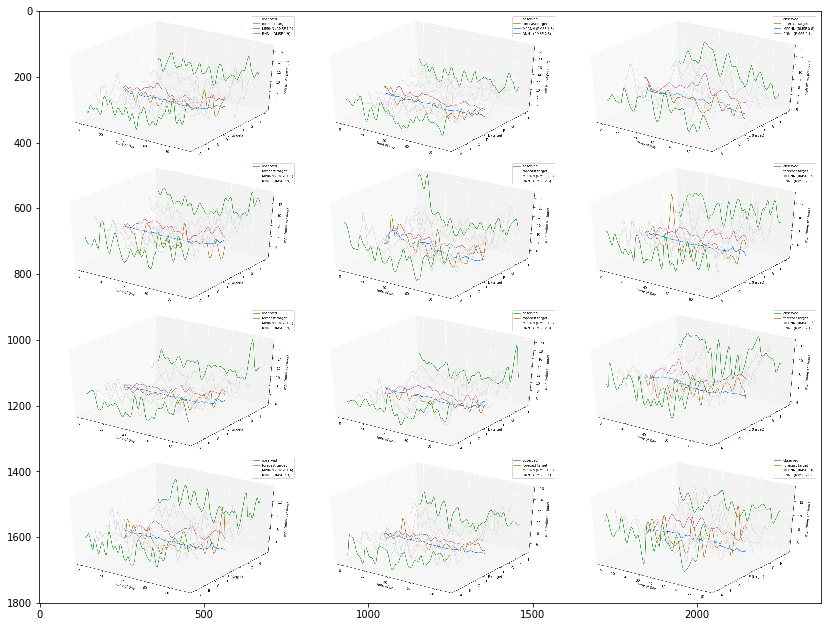

True

In [60]:
cols = []
for col in range(3):
    im = cv2.imread('col_%d.png' % col)
    cols.append(im)
stacked = np.hstack(cols)

plt.figure(figsize=(14, 14))
plt.imshow(stacked)
plt.show(); plt.close()
cv2.imwrite('st_gallery.png', cv2.cvtColor(stacked, cv2.COLOR_BGR2RGB))

In [47]:
# for si, series in enumerate(testset[col*4:(col+1) * 4]):
series = testset[5]

mprnn_sqerr, predicted = forecast_mprnn(
    series, mprnn, graph_file, 
    twoway=True,
    verbose=False, plot=False)
rnn_sqerr, rnn_predicted = forecast_rnn(
    series, rnn, graph_file, 
    verbose=False, plot=False)
print(flat_mean(mprnn_sqerr, level=1), flat_mean(rnn_sqerr, level=1))

8.06589313079603 8.716870424070786


In [63]:
from maps import *
from urllib3.exceptions import *

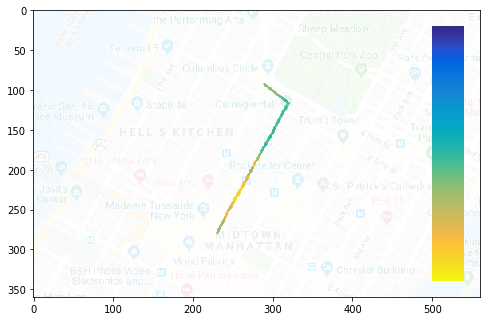

In [68]:
cmap = {}
cmax = 20
mprnn_ints = {}
true_ints = {}
rnn_ints = {}
tstep = 40
ratio = lambda rawval: 1- min(1, rawval / cmax)
unnorm = lambda ls: ls * 10 + 12
for vind, vert in enumerate(vs):
    if vert not in predicted: print('Missing', vert)
    mprnn_ints[vert] = ratio(predicted[vert][tstep])
    rnn_ints[vert] = ratio(rnn_predicted[vert][tstep])
    true_ints[vert] = ratio(unnorm(series[tstep+1, vind]))
# plt.figure(figsize=(14, 3))  
# plt.plot(predicted[vs[0]])
# plt.plot(series[:, 0] * 10 + 12)
# plt.show(); plt.close()
try:
    map_graph('demo', vs, adj, rnn_ints, zoom=14, wait=3, opacity=0.85, crop=120, show=True)
#     map_graph('demo', vs, adj, mprnn_ints, zoom=14, wait=3, opacity=0.85, crop=120, show=True)
#     map_graph('demo', vs, adj, true_ints, zoom=14, wait=3, opacity=0.85, crop=120, show=True)
except MaxRetryError:
    print('RetryError:', fname)
